**PART- B LSGAN**

**Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.**

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

f_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 16859691.16it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301635.63it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5574242.61it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5835750.54it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



**Step2. Train the GAN model to produce images in this new domain**



In [2]:
img, label = f_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


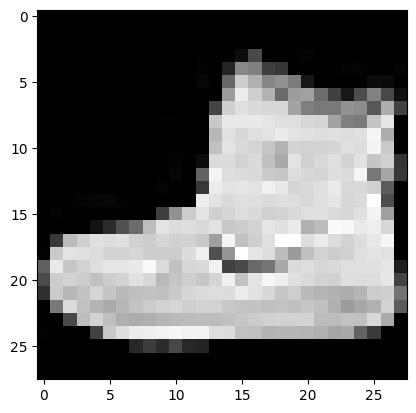

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(f_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([2, 8, 1, 0, 7, 5, 7, 1, 3, 6, 7, 6, 3, 5, 0, 5, 1, 6, 4, 4, 2, 9, 9, 5,
        0, 9, 9, 9, 4, 7, 8, 0, 8, 3, 9, 9, 4, 7, 0, 3, 5, 0, 7, 1, 2, 6, 8, 5,
        5, 5, 4, 5, 1, 1, 0, 9, 6, 1, 9, 5, 1, 2, 6, 0, 6, 0, 2, 0, 4, 7, 4, 8,
        3, 5, 7, 6, 9, 3, 2, 0, 3, 9, 9, 7, 3, 8, 2, 1, 8, 7, 2, 3, 8, 2, 3, 9,
        0, 7, 6, 1])


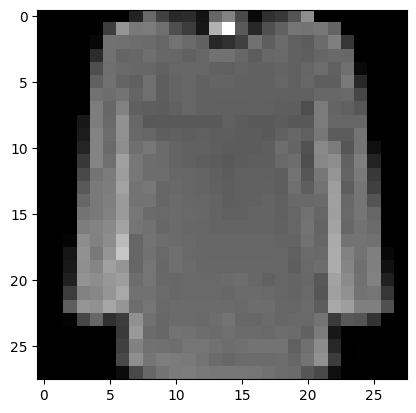

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

**Discriminator Network**

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

LSGAN_D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
LSGAN_D.to(device);

***Generator Network***

In [14]:
latent_size = 64

In [15]:
 LSGAN_G= nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [16]:
y = LSGAN_G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

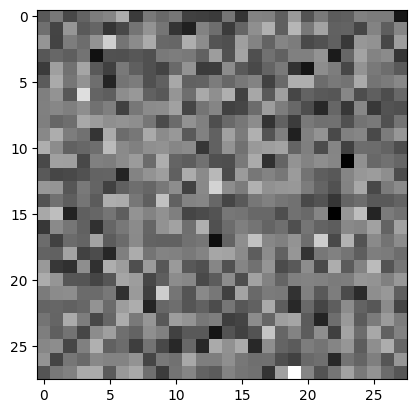

In [17]:
plt.imshow(gen_imgs[0], cmap='gray');

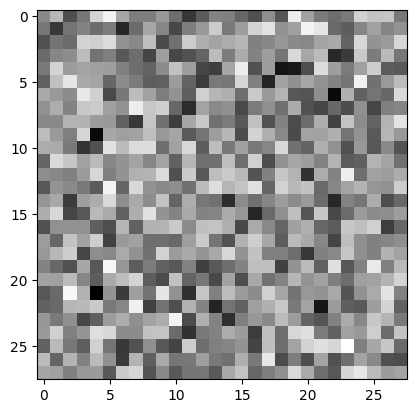

In [18]:
plt.imshow(gen_imgs[1], cmap='gray');

In [19]:
LSGAN_G.to(device);

**Discriminator Training**

In [20]:
criterion = nn.MSELoss()
lsgan_d_optimizer = torch.optim.Adam(LSGAN_D.parameters(), lr=0.0002)

In [22]:
def ls_reset_grad():
    lsgan_d_optimizer.zero_grad()
    lsgan_g_optimizer.zero_grad()

def ls_train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = LSGAN_D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = LSGAN_G(z)
    outputs = LSGAN_D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = 0.5*(d_loss_real + d_loss_fake)
    # Reset gradients
    ls_reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    lsgan_d_optimizer.step()

    return d_loss, real_score, fake_score

**Generator Training**

In [24]:
lsgan_g_optimizer = torch.optim.Adam(LSGAN_G.parameters(), lr=0.0002)

In [34]:
def ls_train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = LSGAN_G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(LSGAN_D(fake_images), labels)

    # Backprop and optimize
    ls_reset_grad()
    g_loss.backward()
    lsgan_g_optimizer.step()
    return g_loss, fake_images

**Training the model**

In [26]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

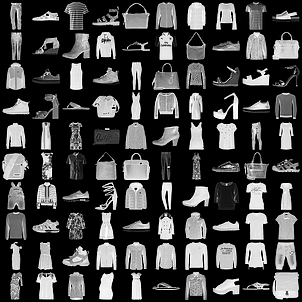

In [27]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


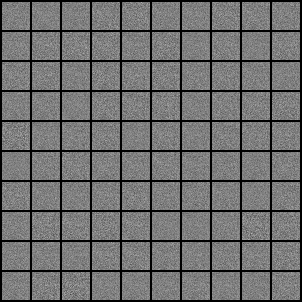

In [28]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = LSGAN_G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [35]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = ls_train_discriminator(images)
        g_loss, fake_images = ls_train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)
    Image('./samples/fake_images-0001.png')

Epoch [0/300], Step [200/600], d_loss: 0.0092, g_loss: 0.9034, D(x): 0.95, D(G(z)): 0.07
Epoch [0/300], Step [400/600], d_loss: 0.0124, g_loss: 0.9280, D(x): 0.97, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.0079, g_loss: 0.9345, D(x): 0.96, D(G(z)): 0.06
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0012, g_loss: 0.9647, D(x): 0.99, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0178, g_loss: 0.9501, D(x): 0.99, D(G(z)): 0.15
Epoch [1/300], Step [600/600], d_loss: 0.0053, g_loss: 0.9734, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0003, g_loss: 0.9866, D(x): 1.00, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0050, g_loss: 0.9768, D(x): 0.99, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0089, g_loss: 0.9190, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0064, g_loss: 0.9667, D(x): 1.00, D(G(z)): 0.06
Epoch [3/300], Step [400/6

**Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.**

In [36]:
# Save the model checkpoints
torch.save(LSGAN_G.state_dict(), 'G.ckpt')
torch.save(LSGAN_D.state_dict(), 'D.ckpt')

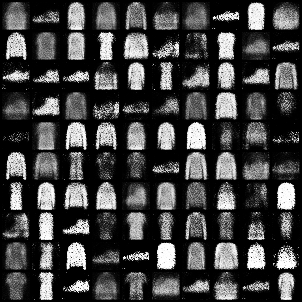

In [37]:
Image('./samples/fake_images-0025.png')

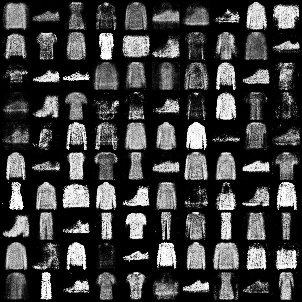

In [38]:
Image('./samples/fake_images-0100.png')

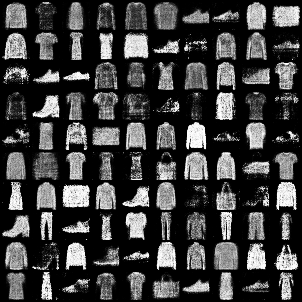

In [39]:
Image('./samples/fake_images-0200.png')

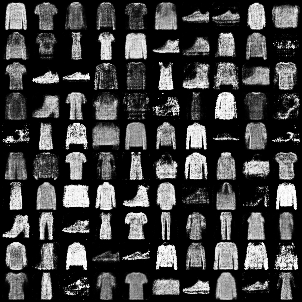

In [40]:
Image('./samples/fake_images-0300.png')

In [41]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

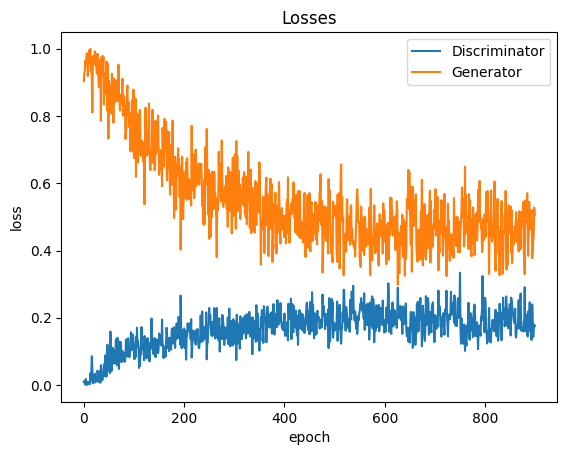

In [42]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

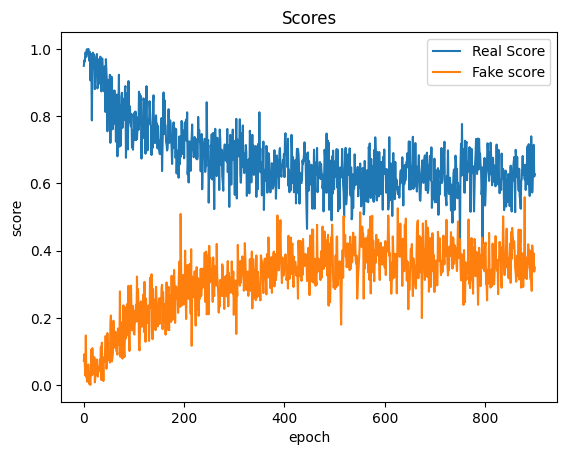

In [43]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

**Step4. Save the model weights in the folder to be used later.**

In [44]:
torch.save(LSGAN_G.state_dict(), 'ls_generator_weights.pth')
torch.save(LSGAN_D.state_dict(), 'ls_discriminator_weights.pth')

**# Step 5: Load the model using the saved weights**

In [45]:
LSGAN_G.load_state_dict(torch.load('ls_generator_weights.pth'))
LSGAN_G.eval()

LSGAN_D.load_state_dict(torch.load('ls_discriminator_weights.pth'))
LSGAN_D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

**Step6:Re-train the GAN model to see if you can improve**

In [46]:
%%time

num_epochs = 300
total_step = len(data_loader)
re_d_losses, re_g_losses, re_real_scores, re_fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = ls_train_discriminator(images)
        g_loss, fake_images = ls_train_generator()


        # Inspect the losses
        if (i+1) % 200 == 0:
            re_d_losses.append(d_loss.item())
            re_g_losses.append(g_loss.item())
            re_real_scores.append(real_score.mean().item())
            re_fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.2407, g_loss: 0.4298, D(x): 0.56, D(G(z)): 0.42
Epoch [0/300], Step [400/600], d_loss: 0.0857, g_loss: 0.6210, D(x): 0.76, D(G(z)): 0.23
Epoch [0/300], Step [600/600], d_loss: 0.2001, g_loss: 0.4611, D(x): 0.63, D(G(z)): 0.40
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.2093, g_loss: 0.3800, D(x): 0.58, D(G(z)): 0.39
Epoch [1/300], Step [400/600], d_loss: 0.1864, g_loss: 0.5038, D(x): 0.59, D(G(z)): 0.30
Epoch [1/300], Step [600/600], d_loss: 0.1589, g_loss: 0.5240, D(x): 0.65, D(G(z)): 0.31
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2117, g_loss: 0.3492, D(x): 0.61, D(G(z)): 0.39
Epoch [2/300], Step [400/600], d_loss: 0.1588, g_loss: 0.4482, D(x): 0.70, D(G(z)): 0.37
Epoch [2/300], Step [600/600], d_loss: 0.3093, g_loss: 0.3387, D(x): 0.55, D(G(z)): 0.53
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2250, g_loss: 0.4200, D(x): 0.55, D(G(z)): 0.37
Epoch [3/300], Step [400/6

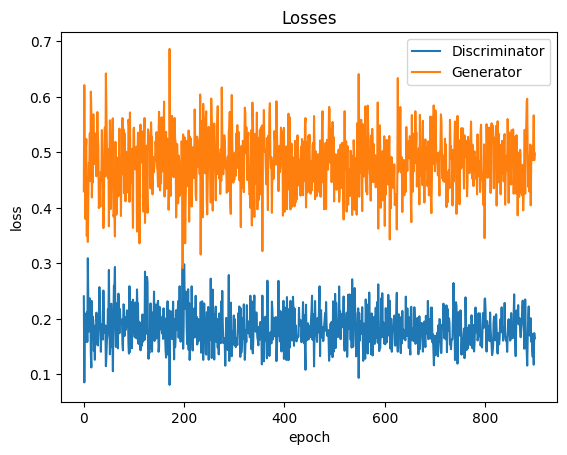

In [47]:
plt.plot(re_d_losses, '-')
plt.plot(re_g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

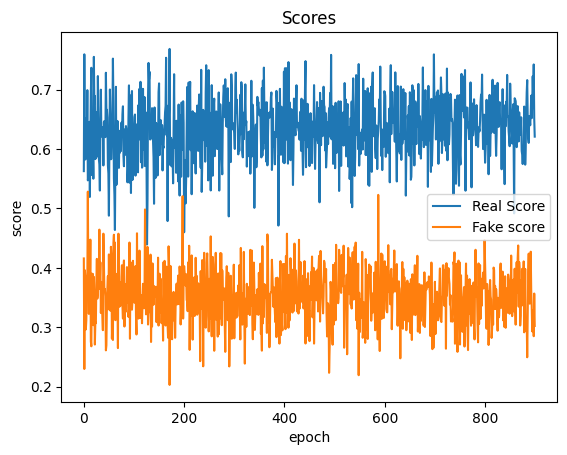

In [48]:
plt.plot(re_real_scores, '-')
plt.plot(re_fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

GAN in PART1 I had used BCELoss has the criterion and the total discriminator loss is d_real_loss + d_fake_loss for GAN. The generator loss in the initial training was around 8 and as the number of epoch increased the loss also decreased reaching 1.8.Initially the discriminator loss was very less(near to 0) and gradually increased upto 2. When the model was retrained the generator loss was between 1.2 to 1.8,and discrimininator was around 0.8 to 1.4.  

Whereas LSGAN uses MCELoss has the cretirion and the total discriminator loss is 0.5 *(d_real_loss + d_fake_loss) for LSGAN.
The generator loss for LSGAN in the initial training was decreased from 1 to 0.05 as the number of epoch increased..Initially the discriminator loss was very less(near to 0) and gradually increased upto 0.5. When the model was retrained the generator loss was between 0.4 to 0.6,and discrimininator was around 0.1 to 0.3.  
The MSELoss minimises the mean squared differnce between Generator and discriminator, whereas BCE loss (more stable training process) is used for binary classification od discriminator.

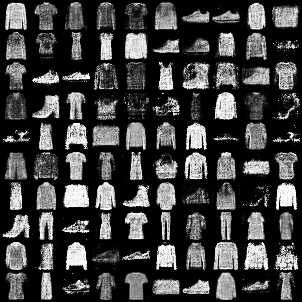

In [53]:
Image('./samples/fake_images-0001.png')

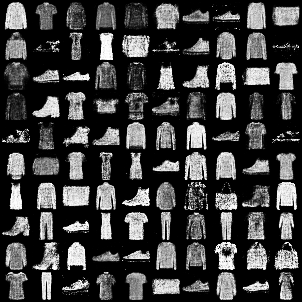

In [54]:
Image('./samples/fake_images-0300.png')